In [2]:
import os
import re

# TODO: fold in golden pianoroll for train (1 pixel wide) and test (many pixels (5ish seconds) wide)

"""
Directories
"""
HOME = os.path.expanduser("~").replace("\\", "/")

#WTC1_WAV_DIR = "/WTC1-WAV"
#WTC2_WAV_DIR = "/WTC2-WAV"

WTC1_MIDI_DIR = "/WTC1-MIDI"
WTC2_MIDI_DIR = "/WTC2-MIDI"

# CQT heatmap slices for CNN training
TRAIN_CQT_CNN_SLICES_IN_DIR = "Train-CQT-CNN-Slices-In"

# Time series text data for full-WAV CQT
TRAIN_TIME_SERIES_IN_DIR = "Train-Time-Series-In"

# CNN output on training data, if needed
TRAIN_PIANOROLL_OUT_DIR = "Train-Pianoroll-Out"

# CNN output on test data
TEST_PIANOROLL_OUT_DIR = "Test-Pianoroll-Out"

# What the CNN output is supposed to be
TEST_PIANOROLL_GOLDEN_DIR = "Test-Pianoroll-Golden"

# CNN output, converted to MIDI for human listening
TEST_MIDI_OUT_DIR = "Test-MIDI-Out"

# CQT heatmap slices for CNN
TEST_CQT_CNN_SLICES_IN_DIR = "Test-CQT-CNN-Slices-In"

# Time series text data for full-WAV CQT
TEST_TIME_SERIES_IN_DIR = "Test-Time-Series-In"

MODEL_CKPT_DIR = "Models"

# corresponds to a max song length of 3 hours
MAX_START_MS_DIGITS = 7

# """
# File name templates
# """
# FUGUE_WAV_NAME_TEMPLATE = "(Fugue_No\._%s)[_\.].+"
# PRELUDE_WAV_NAME_TEMPLATE = "(Prelude_No\._%s)[_\.].+"

# # E.g., Fugue_No._1_Slice_458.png (which means 458 milliseconds in)
# CQT_SLICE_NAME_TEMPLATE = "%s_Slice_(%s).csv"

# # E.g., Fugue_No._1_Pianoroll_6.png
# PIANOROLL_NAME_TEMPLATE = "%s_Pianoroll_(%s).csv"

# # E.g., Fugue_No._1.mid
# MIDI_OUT_NAME_TEMPLATE = "%s.mid"

# RESULTS_PATH = "/numericalResults%s.txt"

"""
Numerical file parameters
"""
CQT_SNAPSHOT_WIDTH_IN_SECONDS = 5
CQT_SNAPSHOT_WIDTH_IN_PIXELS = 1000 # TODO: is it too high? We should have about one solid colored block per pixel
CQT_SNAPSHOT_HEIGHT_IN_PIXELS = 1000

CQT_SAMPLING_RATE = 344.53125 # (which is 44100 / 128)

CQT_SLICE_RADIUS_IN_PIXELS = 2
CQT_SLICE_OFFSET_IN_PIXELS = 3
CQT_SLICE_WIDTH_IN_PIXELS = 1 + 2 * CQT_SLICE_RADIUS_IN_PIXELS

CQT_SLICE_HEIGHT_IN_PIXELS = CQT_SNAPSHOT_HEIGHT_IN_PIXELS

# TRAIN_PIANOROLL_WIDTH_IN_PIXELS = 1
# TEST_PIANOROLL_WIDTH_IN_SECONDS = 5
# TEST_PIANOROLL_WIDTH_IN_PIXELS = float(TEST_PIANOROLL_WIDTH_IN_SECONDS) * TRAIN_PIANOROLL_WIDTH_IN_PIXELS / CQT_SLICE_WIDTH_IN_PIXELS * CQT_SNAPSHOT_WIDTH_IN_PIXELS / CQT_SNAPSHOT_WIDTH_IN_SECONDS

"""
Hyperparameters
"""
#CONTEXT_WINDOW_ROWS = 352
CONTEXT_WINDOW_ROWS = 288
CONTEXT_WINDOW_COLS = 5
NUM_RGB_CHANNELS = 1

NUM_KEYS = 88
DROPOUT_P = 0.25
NUM_EPOCHS = 10
BATCH_SIZE = 8
SEQUENCE_LENGTH_IN_SLICES = 50 # (~5 seconds)
SEQUENCE_SAMPLE_FREQ_IN_SLICES = 175

NUM_PIECES_TO_TEST = 4
TEST_SPLIT = 0.25
VALIDATION_SPLIT = 0.333

# CHECKPOINT_EPOCH = 80
# CHECKPOINT_VAL_LOSS = 0.49

CHECKPOINT_EPOCH = 100
CHECKPOINT_VAL_LOSS = 0.17

BINS_PER_OCTAVE = 36
FILTER_SCALE = 0.5
HOP_LENGTH = 128

"""
File conversion parameters
"""
NOISE_PARAMETER = 0.01
DEFAULT_SOUND_FONT = '~/.fluidsynth/default_sound_font.sf2'
SAMPLE_RATE_IN_HZ = 1000


In [12]:
import os
import numpy as np
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pretty_midi
import csv
import pdb
import argparse
import threading
import time
import math
import h5py
import librosa, librosa.display

In [17]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """

    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """

    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))

    return g


def get_data(piece):
    hf = h5py.File(piece, "r")
    slices = np.array(hf.get("slice_indices"))
    cqt = np.array(hf.get("cqt"))
    pianoroll = np.array(hf.get("pianoroll"))
    slice_index = 0

    return slices, cqt, pianoroll, slice_index


@threadsafe_generator
def generator(pieces, batch_size=BATCH_SIZE):
    """
    Yield one batch at a time of inputs to the CNN.
    """
    piece_index = 0
    piece_slices, piece_cqt, piece_pianoroll, slice_index = get_data(pieces[piece_index])

    while True:
        # In this iteration of the loop, yield a single batch of sequences
        batch_X = np.zeros((batch_size, SEQUENCE_LENGTH_IN_SLICES, CONTEXT_WINDOW_ROWS, CONTEXT_WINDOW_COLS, 1))
        batch_Y = np.zeros((batch_size, SEQUENCE_LENGTH_IN_SLICES, NUM_KEYS))
        reached_end_of_dataset = False
        for batch_sequence_index in range(batch_size):
            if slice_index + SEQUENCE_LENGTH_IN_SLICES > piece_slices.shape[0]:
                # We can't make another full sequence with this piece
                if piece_index + 1 >= len(pieces):
                    # We've reached the end of an epoch--don't yield these incomplete batches
                    reached_end_of_dataset = True
                    break

                # Skipping to the next piece
                piece_index += 1
                piece_slices, piece_cqt, piece_pianoroll, slice_index = get_data(pieces[piece_index])

            # Continue constructing the batch by constructing a sequence and adding it to the batch
            sequence_slices = piece_slices[slice_index:(slice_index + SEQUENCE_LENGTH_IN_SLICES)]
            sequence_cqt = np.zeros((SEQUENCE_LENGTH_IN_SLICES, CONTEXT_WINDOW_ROWS, CONTEXT_WINDOW_COLS))
            sequence_pianoroll = np.zeros((SEQUENCE_LENGTH_IN_SLICES, NUM_KEYS))
            for sequence_index, slice in enumerate(sequence_slices):
                [start, end] = slice
                sequence_cqt[sequence_index, :, :] = piece_cqt[:, start:end]
                sequence_pianoroll[sequence_index, :] = np.max(piece_pianoroll[:, start:end], axis=1)

            # Add new sequence to the batches
            batch_X[batch_sequence_index, :, :, :, 0] = sequence_cqt
            batch_Y[batch_sequence_index, :, :] = sequence_pianoroll

            # Increment slice index and go to the next sequence
            slice_index += SEQUENCE_SAMPLE_FREQ_IN_SLICES

        # Batch is done being constructed, yield to CNN
        if reached_end_of_dataset:
            # We weren't able to fill out this batch, just reset everything and let the while-loop restart
            piece_index = 0
            piece_slices, piece_cqt, piece_pianoroll, slice_index = get_data(pieces[piece_index])
        else:
#             pdb.set_trace()
            librosa.display.specshow(batch_X[0, 35, :, :, 0], x_axis='time', y_axis='chroma', hop_length=64)
            print(batch_Y[0, 35])
            return
            yield batch_X, batch_Y


def num_samples(dataset):
    """
    Find the number of sequences given by the dataset.
    """
    total_num_sequences = 0
    for piece in dataset:
        hf = h5py.File(piece, "r")
        num_slices = np.array(hf.get("slice_indices")).shape[0]
        num_sequences = (num_slices + SEQUENCE_SAMPLE_FREQ_IN_SLICES - SEQUENCE_LENGTH_IN_SLICES) \
            // SEQUENCE_SAMPLE_FREQ_IN_SLICES # trim so that there's a whole number of sequences
        total_num_sequences += num_sequences

    return total_num_sequences


def create_model():
    """
    Specifies a simple CNN/LSTM recurrent neural network.
    """
    model = Sequential()

    conv = Conv2D(filters=20,
                 kernel_size=(20, 2),
                 strides=(1, 1),
                 padding='SAME',
                 activation='relu')
    model.add(TimeDistributed(conv, input_shape=(SEQUENCE_LENGTH_IN_SLICES, CONTEXT_WINDOW_ROWS, CONTEXT_WINDOW_COLS, 1)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 2), strides=(2, 1))))
    model.add(TimeDistributed(Conv2D(20, kernel_size=(20, 2), strides=(10, 1), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 2), strides=(2, 1))))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(500)))
    model.add(LSTM(500, input_shape=(SEQUENCE_LENGTH_IN_SLICES, 500), return_sequences=True))
    model.add(LSTM(200, input_shape=(SEQUENCE_LENGTH_IN_SLICES, 500), return_sequences=True))
    model.add(TimeDistributed(Dense(88, activation = "sigmoid")))

    return model


def train_model(pieces):
    """
    Trains CNN and evaluates it on test set. Checkpoints are saved in a directory.

    Inspired by https://github.com/chaumifan/DSL_Final
    """

    print('Creating CNN model\n')
    model = create_model()
    print('Compiling CNN model\n')
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

    print(model.summary())

    history = AccuracyHistory()
    checkpoint_path = os.path.join(MODEL_CKPT_DIR, 'ckpt.h5')
    checkpoint = ModelCheckpoint(checkpoint_path + 'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', period=10)
    
    boundary = math.floor((1.0 - VALIDATION_SPLIT) * len(pieces))
    train_pieces = pieces[:boundary]
    valid_pieces = pieces[boundary:]

    num_train_samples = num_samples(train_pieces)
    num_valid_samples = num_samples(valid_pieces)

    print("Number of ~5s training sequences:", num_train_samples)
    print("Number of ~5s validation sequences:", num_valid_samples)

    model.fit_generator(generator=generator(train_pieces),
                        steps_per_epoch=num_train_samples // BATCH_SIZE,
                        validation_data=generator(valid_pieces),
                        validation_steps=num_valid_samples // BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        verbose=1,
                        callbacks=[history, checkpoint])

    return model, history


def evaluate_model(x_test, y_test, model, history):
    score = model.evaluate(x_test, y_test, verbose=0)

    print('Train loss: ', score[0])
    print('Train accuracy: ', score[1])

    print(history.acc)

    plt.plot(range(1, NUM_EPOCHS + 1), history.acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('test_loss.png')

    
class AccuracyHistory(keras.callbacks.Callback):
    """
    Callback for keeping record of training accuracy.

    From http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
    """
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))


def restore_model(epoch, val_loss):
    checkpoint_path = "Models/"    
    model = create_model()
    file = checkpoint_path + 'ckpt.h5weights.%d-%.2f.hdf5' % (epoch, val_loss)
    model.load_weights(file)
    return model


def make_predictions(cqt_data, midiFilename):
    """
    Given a set of cqt_slice_paths, runs predict on each slice and adds CNN
    output as a column to pianoroll prediction. Writes pianoroll prediction to file.
    """
    
    model = restore_model(CHECKPOINT_EPOCH, CHECKPOINT_VAL_LOSS)
    print("CNN model restored.")
    cqt_array = np.array(cqt_data)

    predictions = None
    for i in range(cqt_array.shape[1]):
        small_slice = cqt_array[:,i]
        repeated_slice = np.asarray([[row] * 9 for row in small_slice])
        cqt_slice = np.expand_dims(repeated_slice, 3)
        cqt_slice = np.expand_dims(cqt_slice, 0)
        pred = model.predict(cqt_slice)
        bool_array = pred >= 0.5
        result = bool_array.astype(int)
        if predictions is None:
            predictions = result.T
        else:
            predictions = np.hstack((predictions, result.T))
    print("Pianoroll predictions made.")

    outPianorollPath = os.path.join(TEST_PIANOROLL_OUT_DIR, midiFilename).replace("\\", "/")
    np.savetxt(outPianorollPath, predictions, fmt='%i', delimiter='\t')
    

Creating CNN model

Compiling CNN model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 50, 288, 5, 20)    820       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 50, 143, 4, 20)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 50, 13, 3, 20)     16020     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 50, 5, 2, 20)      0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 50, 200)           0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 50, 500)           100500    
_________________________________________________________________
lstm_3 (LSTM)

StopIteration: 

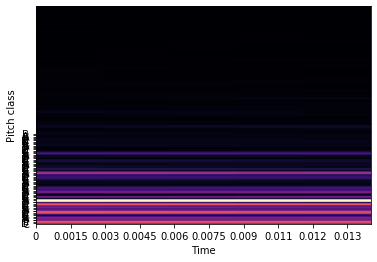

In [18]:
piece_paths = [os.path.join("C:\\Users\\aitan\\Documents\\cs230project\\sample-h5", h5_file) \
    for h5_file in os.listdir("C:\\Users\\aitan\\Documents\\cs230project\\sample-h5") if "Chamber" not in h5_file]

# Split pieces into train/test
boundary = math.floor((1.0 - TEST_SPLIT) * len(piece_paths))
train_pieces = piece_paths[:boundary]
test_pieces = piece_paths[boundary:]

model, history = train_model(train_pieces)